In [ ]:
!pip install lifelines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Return predictive performance of a pathway
import time, os, math, random
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy.stats as stat
from sklearn.preprocessing import StandardScaler # zscore standardization
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import lifelines; from lifelines.statistics import logrank_test; from lifelines import KaplanMeierFitter

In [ ]:
%cd '/content/drive/MyDrive/4060HW/final/organoid_biomarker_detection/python'

/content/drive/MyDrive/4060HW/final/organoid_biomarker_detection/python


In [ ]:
## Initialize
test_types = {'coad':'FLUOROURACIL'}
ML_algorithm_list = ['Ridge', 'SVR', 'LinearRegression']
pathway_source = 'reactome'
n_jobs = 10
network = 'STRING_700'
zscore_cutoff = -1.2816
testing_pathway_rank = 1
tmp_dir = './results/single_pathway_predictions'

start_time = time.ctime()

In [ ]:
## Parse proximal pathways
def return_proximal_pathways(network, pathway_source, zscore_cutoff):
	'''
	output = { drug : [ proximal pathways ] }
	'''
	output = defaultdict(list)
	if pathway_source.lower() == 'reactome':
		df = pd.read_csv('../data/coad_blca_organoid_drugs_zscore_result_reactome.txt', sep='\t')
		tmp_drugs = df.drop(df.columns[0],axis=1).columns
		for tmp_drug in tmp_drugs:
			for drug in tmp_drug.split('_'):
				pathway_list = list(df.loc[df[tmp_drug]<=zscore_cutoff, :]['Pathway'])
				output[drug] = pathway_list
	return output

In [ ]:
## Output file
fo_all = open('%s/single_pathway_predictions.txt'%(tmp_dir), 'w')
print('\t'.join(['cancer_type', 'drug', 'ML', 'pathway_rank', 'pathway', '5yr_responder', '5yr_nonresponder', 'pvalue']), file=fo_all)

fo_all_coef = open('%s/single_pathway_coefficients.txt'%(tmp_dir), 'w')
print('\t'.join(['cancer', 'drug','num_samples','ML', 'pathway', 'reg_coef', 'abs_reg_coef']), file=fo_all_coef)

In [ ]:
## Analyze
for ML in ML_algorithm_list:
	# set directory
	fo_dir = tmp_dir
	if os.path.isdir('%s/%s'%(fo_dir, ML)) == False:
		os.mkdir('%s/%s'%(fo_dir, ML))
	fo_dir = '%s/%s'%(fo_dir, ML)

	# cancer specific analysis
	for cancer_type in test_types:
		drug = test_types[cancer_type]
		print('\n\n-----------------\ntesting for %s / %s / %s,  '%(cancer_type, drug, ML), time.ctime())


		## Import data
		c_dir = os.getcwd()
		os.chdir('../utilities')
		exec(compile(open('parse_patient_clinical_data.py', "rb").read(), 'parse_patient_clinical_data.py', 'exec'), globals())
		exec(compile(open('parse_preclinical_model_data.py', "rb").read(), 'parse_preclinical_model_data.py', 'exec'), globals())
		exec(compile(open('parse_ssGSEA.py', "rb").read(), 'parse_ssGSEA.py', 'exec'), globals())
		nes_dic = parse_ssGSEA_NES(cancer_type, 'organoid', pathway_source) 
		response_dic, drugList = parse_organoid_drug_response_commonDrugID(cancer_type, 'IC50')
		network_dic = return_proximal_pathways(network, pathway_source, zscore_cutoff) # { drug : [ pathways ] }

		drugPat, patDrug = parse_TCGA_drug_treatment_data(cancer_type)
		surDic = parse_TCGA_survival_data_boolean_format(cancer_type)
		patNES = parse_ssGSEA_NES(cancer_type, 'TCGA', pathway_source)
		
		if pathway_source.lower() == 'reactome':
			feature_list = reactome_genes_uniprot()
			feature_list = list(feature_list.keys())
		os.chdir(c_dir)


		## feature_list // proximal pathways only
		for sample in nes_dic:
			feature_list = list(set(feature_list) & set(nes_dic[sample].keys()))
		for pat in list(set(surDic.keys())&set(patNES.keys())):
			feature_list = list(set(feature_list)&set(patNES[pat].keys()))
		feature_list = list(set(feature_list) & set(network_dic[drug]))

		## Predict drug response
		# scale expressions (organoid)
		expList, samples, responses = [], [], []
		for sample in list(set(nes_dic.keys())&set(response_dic.keys())):
			if drug in response_dic[sample]:
				samples.append(sample)#; samples = sorted(samples, reverse=True)
				responses.append(response_dic[sample][drug])
		for sample in samples:
			tmp = []
			for feature in feature_list:
				if feature in network_dic[drug]: # proximal pathways only
					tmp.append(nes_dic[sample][feature])
			expList.append(tmp)
		scaler = StandardScaler()
		scaler.fit(expList)
		scaled_expList = scaler.transform(expList) # scaled expression
		scaled_expList = np.array(scaled_expList)

		# regression (organoid)
		if ML == 'Ridge':
			regr = RidgeCV(cv=3, alphas=np.arange(0.1,1,0.1)).fit(scaled_expList, responses)
		if ML == 'SVR':
			regr = SVR(kernel='linear').fit(scaled_expList, responses)
		if ML == 'LinearRegression':
			regr = LinearRegression().fit(scaled_expList, responses)
		feature_importance = list(regr.coef_)
		if ML == 'SVR':
			feature_importance = feature_importance[0]

		# feature ranks
		coef_dic = {} # { feature : coefficient }
		abs_coef_dic = {}
		for feature, coef in zip(feature_list, feature_importance):
			# print regression coefficients
			print('\t'.join(map(str, [cancer_type, drug, len(samples), ML, feature, coef, np.abs(coef)])), file=fo_all_coef)
			# coefficents
			coef_dic[feature] = coef
			abs_coef_dic[feature] = np.abs(coef)
		r = {key: rank for rank, key in enumerate(sorted(set(abs_coef_dic.values()), reverse=True), 1)}
		feature_rank_dic = {k: r[v] for k,v in list(abs_coef_dic.items())}
		

		# scale expressions (patient)
		pat_expDic = {} # { pat : { feature : scaled expression } }
		pat_expList, pat_samples = [], []
		for pat in list(set(surDic.keys())&set(patNES.keys())):
			pat_samples.append(pat)
			tmp = []
			for feature in feature_list:
				tmp.append(patNES[pat][feature])
			pat_expList.append(tmp)
		scaler = StandardScaler()
		scaler.fit(pat_expList)
		scaled_pat_expList = scaler.transform(pat_expList)

		for p_index, pat in enumerate(pat_samples):
			pat_expDic[pat] = {}
			for f_index, feature in enumerate(feature_list):
				pat_expDic[pat][feature] = scaled_pat_expList[p_index][f_index]
		
		# single-pathway prediction
		features_used = []; coef_used = []
		for fi_index, fi in enumerate(feature_importance):
			feature = feature_list[fi_index]
			if testing_pathway_rank == feature_rank_dic[feature]:
				features_used.append(feature); coef_used.append(fi)

			
		# predicted drug response (patient)
		pred_response = {} # { pat : predicted drug response }
		month_dic, status_dic = defaultdict(list), defaultdict(list)
		fiveYear_dic = {} # { predicted response : 5 year survival }

		for pat in list(set(pat_expDic.keys())&set(drugPat[drug])&set(surDic.keys())):
			pred_r = 0
			for feature, coef in zip(features_used, coef_used):
				pred_r += coef * pat_expDic[pat][feature]
			pred_response[pat] = pred_r

		# classify patients
		response_cutoff = np.median(list(pred_response.values()))
		for pat in pred_response:
			if pred_response[pat] <= response_cutoff:
				cls = 'Responder'
			else:
				cls = 'Nonresponder'
			month_dic[cls].append(surDic[pat]['months'])
			status_dic[cls].append(surDic[pat]['status'])
		
		# logrank Test
		results = logrank_test(month_dic['Responder'], month_dic['Nonresponder'], event_observed_A=status_dic['Responder'], event_observed_B=status_dic['Nonresponder'])
		pvalue = results.p_value
		
		for cls in month_dic:
			kmf = KaplanMeierFitter()
			kmf.fit(month_dic[cls], status_dic[cls])
			fiveYear_dic[cls] = kmf.predict(60)

		# draw survival plot
		f = plt.figure(figsize=(4,4))
		ax = f.add_subplot(1,1,1)
		plt.title('%s / %s / %s / %s\npvalue=%.4f\n'%(cancer_type, drug, ML, testing_pathway_rank, pvalue), fontsize=8)
		
		c1 = KaplanMeierFitter()
		ax = c1.fit(month_dic['Responder'], status_dic['Responder'], label='Responder (n=%s)'%len(month_dic['Responder'])).plot(ax=ax, ci_show=True, c='r')
		

		c2 = KaplanMeierFitter()
		ax = c1.fit(month_dic['Nonresponder'], status_dic['Nonresponder'], label='Nonresponder (n=%s)'%len(month_dic['Nonresponder'])).plot(ax=ax, ci_show=True, c='b')
		
		plt.xlabel('Survival (months)')
		plt.ylabel('Percent survival')
		ymin, ymax = 0, 1.1
		plt.ylim(ymin, ymax)
		plt.plot([60, 60], [ymin, ymax], c='k', linestyle='--')
		plt.tight_layout()
		plt.savefig('%s/%s_%s_rank_%s.jpg'%(fo_dir, cancer_type, drug, testing_pathway_rank), format='jpg')
		plt.savefig('%s/%s_%s_rank_%s.eps'%(fo_dir, cancer_type, drug, testing_pathway_rank), format='eps', dpi=300)
		plt.close()

fo_all.close()		
fo_all_coef.close()
print('process complete, start time: %s - end time: %s ' %(start_time, time.ctime()))



-----------------
testing for coad / FLUOROURACIL / Ridge,   Mon Dec 20 21:10:24 2021


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.




-----------------
testing for coad / FLUOROURACIL / SVR,   Mon Dec 20 21:10:42 2021


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.




-----------------
testing for coad / FLUOROURACIL / LinearRegression,   Mon Dec 20 21:11:16 2021


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


process complete, start time: Mon Dec 20 21:10:24 2021 - end time: Mon Dec 20 21:11:25 2021 


In [ ]:
output = defaultdict(list)
if pathway_source.lower() == 'reactome':
  df_zscore = pd.read_csv('/content/drive/MyDrive/4060HW/final/organoid_biomarker_detection/data/coad_blca_organoid_drugs_zscore_result_reactome.txt', sep='\t')
  tmp_drugs = df_zscore.drop(df_zscore.columns[0],axis=1).columns
  for tmp_drug in tmp_drugs:
    for drug in tmp_drug.split('_'):
      pathway_list = list(df_zscore.loc[df_zscore[tmp_drug]<=zscore_cutoff, :]['Pathway'])
      output[drug] = pathway_list

In [ ]:
output['FLUOROURACIL']

['REACTOME_ASSOCIATION_OF_LICENSING_FACTORS_WITH_THE_PRE_REPLICATIVE_COMPLEX',
 'REACTOME_REVERSIBLE_HYDRATION_OF_CARBON_DIOXIDE',
 'REACTOME_SULFUR_AMINO_ACID_METABOLISM',
 'REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT',
 'REACTOME_BASE_EXCISION_REPAIR',
 'REACTOME_G1_S_SPECIFIC_TRANSCRIPTION',
 'REACTOME_SYNTHESIS_AND_INTERCONVERSION_OF_NUCLEOTIDE_DI_AND_TRIPHOSPHATES',
 'REACTOME_REMOVAL_OF_THE_FLAP_INTERMEDIATE_FROM_THE_C_STRAND',
 'REACTOME_G1_S_TRANSITION',
 'REACTOME_CELL_CYCLE',
 'REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM',
 'REACTOME_CDC6_ASSOCIATION_WITH_THE_ORC_ORIGIN_COMPLEX',
 'REACTOME_E2F_MEDIATED_REGULATION_OF_DNA_REPLICATION',
 'REACTOME_UNWINDING_OF_DNA',
 'REACTOME_POL_SWITCHING',
 'REACTOME_AMINO_ACID_SYNTHESIS_AND_INTERCONVERSION_TRANSAMINATION',
 'REACTOME_RESOLUTION_OF_AP_SITES_VIA_THE_MULTIPLE_NUCLEOTIDE_PATCH_REPLACEMENT_PATHWAY',
 'REACTOME_MITOTIC_G1_G1_S_PHASES',
 'REACTOME_PYRIMIDINE_CATABOLISM',
 'REACTOME_E2F_ENABLED_INHIBITION_OF_PRE_REPLICATION_COMPLEX_FORMATIO

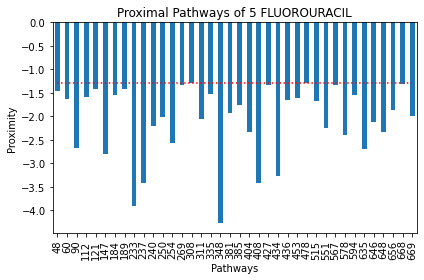

In [ ]:
df_zscore_5FU = df_zscore[df_zscore["FLUOROURACIL"]<=zscore_cutoff]

df_zscore_5FU['FLUOROURACIL'].plot.bar(title="Proximal Pathways of 5 FLUOROURACIL")
plt.xlabel('Pathways')
plt.ylabel('Proximity')
x = np.arange(0,38)
y = (zscore_cutoff)*np.ones(38)
plt.plot(x,y,color='red', linestyle=':')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/4060HW/final/organoid_biomarker_detection/python/results/single_pathway_predictions/single_pathway_coefficients.txt", sep="\t")
group_obj = df.groupby(by='ML')

ml_class = df["ML"].unique()
ml_class

array(['Ridge', 'SVR', 'LinearRegression'], dtype=object)

In [ ]:
for i in ml_class:
  data = df[df["ML"].isin([i])]
  exec("df_%s=data"%i)

df_Ridge

,cancer,drug,num_samples,ML,pathway,reg_coef,abs_reg_coef
0,coad,FLUOROURACIL,19,Ridge,REACTOME_VITAMIN_B5_PANTOTHENATE_METABOLISM,-0.222888,0.222888
1,coad,FLUOROURACIL,19,Ridge,REACTOME_REMOVAL_OF_THE_FLAP_INTERMEDIATE_FROM...,-0.303135,0.303135
2,coad,FLUOROURACIL,19,Ridge,REACTOME_PURINE_METABOLISM,0.046505,0.046505
3,coad,FLUOROURACIL,19,Ridge,REACTOME_BASE_EXCISION_REPAIR,0.262181,0.262181
4,coad,FLUOROURACIL,19,Ridge,REACTOME_REVERSIBLE_HYDRATION_OF_CARBON_DIOXIDE,0.595075,0.595075
5,coad,FLUOROURACIL,19,Ridge,REACTOME_METABOLISM_OF_NUCLEOTIDES,-0.148109,0.148109
6,coad,FLUOROURACIL,19,Ridge,REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM,0.197652,0.197652
7,coad,FLUOROURACIL,19,Ridge,REACTOME_CELL_CYCLE,0.110502,0.110502
8,coad,FLUOROURACIL,19,Ridge,REACTOME_E2F_ENABLED_INHIBITION_OF_PRE_REPLICA...,-0.059690,0.059690
9,coad,FLUOROURACIL,19,Ridge,REACTOME_SULFUR_AMINO_ACID_METABOLISM,-0.391486,0.391486


In [ ]:
df_LR=df_LinearRegression.reset_index()
df_SVR=df_SVR.reset_index()

df_Ridge.sort_values("abs_reg_coef",ascending=False,inplace=True)
df_LR.sort_values("abs_reg_coef",ascending=False,inplace=True)
df_SVR.sort_values("abs_reg_coef",ascending=False,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


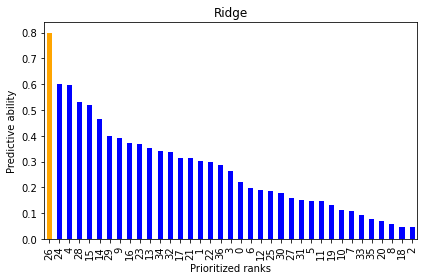

In [ ]:
color_list = ["orange"]
for i in range(36):
  color_list.append("b")

df_Ridge['abs_reg_coef'].plot.bar(title="Ridge",color=color_list)
plt.xlabel('Prioritized ranks')
plt.ylabel('Predictive ability')
plt.tight_layout()
plt.show()